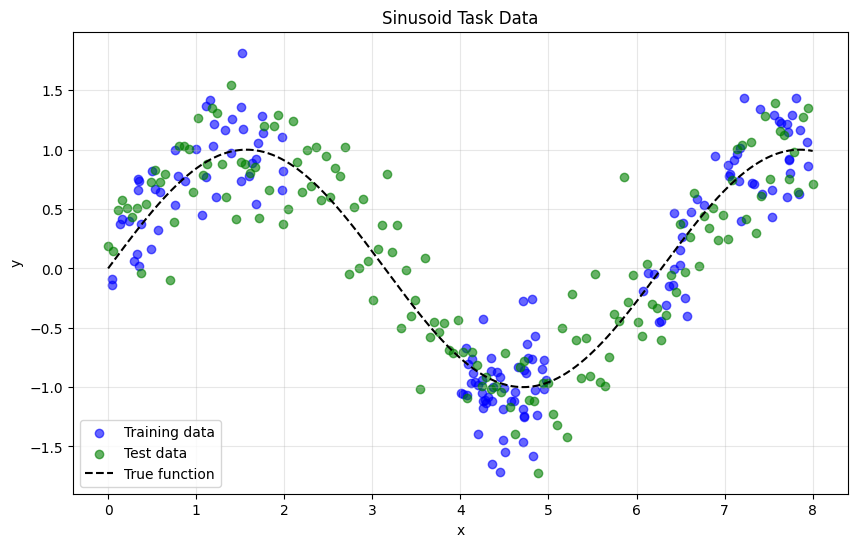

In [9]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example
from plotting import plot_sinusoid_task, plot_gp_prediction
jax.config.update("jax_enable_x64", False)


n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
num_calibration_samples = 50
num_test_samples = 150

batch_size = 20
X_train, y_train, X_valid, y_valid, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=0.3,
    intervals=[(0, 2), (4, 5), (6, 8)],
    rng_key=jax.random.key(0)
)
train_loader = DataLoader(X_train, y_train, batch_size)

fig = plot_sinusoid_task(X_train, y_train, X_test, y_test)

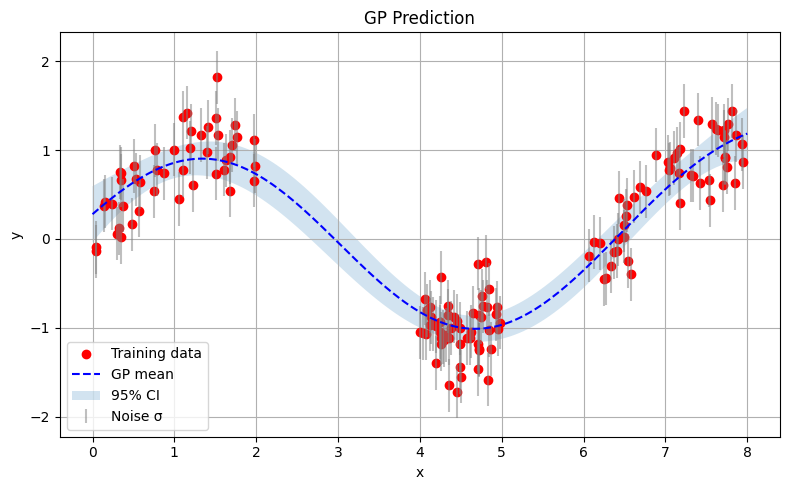

In [10]:
from helper import gp_regression

pred_mean, pred_cov, kernel_fn = gp_regression(
    X_train,
    y_train,
    X_test,
    kernel_name="rbf",
    kernel_params={"lengthscale": 2.6},
    noise_variance=0.3,
)

std_dev = jnp.sqrt(jnp.maximum(jnp.diag(pred_cov), 0))

fig = plot_gp_prediction(
    X_train, y_train, X_test, pred_mean, std_dev, noise_std=0.3
)

In [11]:
from laplax.curv.fsp import create_fsp_objective

# Create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear2(nnx.tanh(self.linear1(x)))
        return x


model = Model(in_channels=1, hidden_channels=64, out_channels=1, rngs=nnx.Rngs(0))
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


def mse_loss(x, y):
    return (0.5 * jnp.sum((x - y) ** 2))


fsp_loss_fn = create_fsp_objective(
    model_fn,
    loss_fn=mse_loss,
    prior_mean=jnp.zeros((150)),
    prior_cov_kernel=kernel_fn,
)

[epoch 0]: loss: 2080.8967
[epoch 100]: loss: 2739.4099
[epoch 200]: loss: 153.3812
[epoch 300]: loss: 2345.4548
[epoch 400]: loss: 976.2141
[epoch 500]: loss: 1273.9720
[epoch 600]: loss: 3137.0046
[epoch 700]: loss: 265.2692
[epoch 800]: loss: 204.6289
[epoch 900]: loss: 403.7563
Final loss: 244.2914


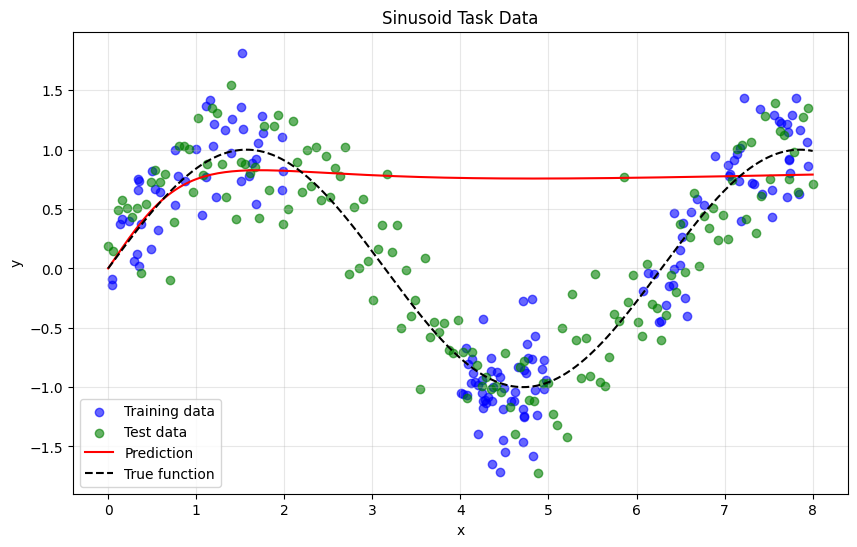

In [13]:
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(m):
        data = {"inputs": x, "targets": y}
        return fsp_loss_fn(
            data, data["inputs"], params
        )  # mse_loss(m, x, y) + reg_loss(m, kernel_fn, x)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # Inplace updates

    return loss


def train_model(model, n_epochs, lr=1e-3):
    # Create optimizer
    optimizer = nnx.Optimizer(model, optax.adam(lr))  # Reference sharing

    # Train epoch
    for epoch in range(n_epochs):
        for x_tr, y_tr in train_loader:
            loss = train_step(model, optimizer, x_tr, y_tr)

        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f}")

    print(f"Final loss: {loss:.4f}")
    return model


model = train_model(model, n_epochs=1000)

X_pred = jnp.linspace(0., 8., 200).reshape(200, 1)
y_pred = jax.vmap(model)(X_pred)

_ = plot_sinusoid_task(X_train, y_train, X_test, y_test, X_pred, y_pred)

In [14]:
import jax
import jax.numpy as jnp
import optax
from optax import tree_utils as otu
import orbax.checkpoint as ocp
from flax import nnx
from helper import DataLoader, get_sinusoid_example
from matplotlib import pyplot as plt
from plotting import plot_sinusoid_task, plot_gp_prediction

from laplax.curv.cov import Posterior
from laplax.curv.fsp import create_fsp_objective
from laplax.curv.lanczos_isqrt import lanczos_isqrt
from jax.flatten_util import ravel_pytree

from laplax.util.flatten import create_partial_pytree_flattener
import laplax
from laplax.curv import estimate_curvature
from functools import partial


In [ ]:
jax.config.update("jax_enable_x64", True)

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
num_calibration_samples = 50
num_test_samples = 150

batch_size = 20
X_train, y_train, X_valid, y_valid, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=0.3,
    intervals=[(0, 8)],
    rng_key=jax.random.key(0),
    dtype=jnp.float64,
)
train_loader = DataLoader(X_train, y_train, batch_size)


class RBFKernel:
    def __init__(self, lengthscale=2.60):
        self.lengthscale = lengthscale

    def __call__(self, x, y: jax.Array | None = None) -> jax.Array:
        """Compute RBF kernel between individual points"""
        if y is None:
            y = x

        sq_dist = jnp.sum((x - y) ** 2)

        return jnp.exp(-0.5 * sq_dist / self.lengthscale**2)


class Periodic:
    def __init__(self, lengthscale=2.60, period=2.0):
        self.lengthscale = lengthscale
        self.period = period

    def __call__(self, x, y: jax.Array | None = None) -> jax.Array:
        if y is None:
            y = x

        sine_squared = (jnp.sin(jnp.pi * (x - y) / self.period) / self.lengthscale) ** 2
        K = jnp.exp(-0.5 * jnp.sum(sine_squared, axis=0))
        return K.squeeze() * RBFKernel(self.lengthscale)(x, y)



class L2InnerProductKernel:
    def __init__(self, bias=1e-4):
        self.bias = bias

    def __call__(self, x1: jax.Array, x2: jax.Array | None = None) -> jax.Array:
        """Compute L² inner product kernel between x1 and x2."""
        if x2 is None:
            x2 = x1

        return jnp.sum(x1 * x2) + self.bias


def build_covariance_matrix(kernel, X1, X2):
    return jnp.array([[kernel(x1, x2) for x2 in X2] for x1 in X1])


def gp_regression(x_train, y_train, x_test, kernel, noise_variance=1e-2):
    K = build_covariance_matrix(kernel, x_train, x_train)

    K_noise = K + noise_variance * jnp.eye(K.shape[0])

    alpha = jnp.linalg.solve(K_noise, y_train)

    K_star = build_covariance_matrix(kernel, x_test, x_train)

    mu_star = K_star @ alpha

    K_ss = build_covariance_matrix(kernel, x_test, x_test)
    v = jnp.linalg.solve(K_noise, K_star.T)
    cov_star = K_ss - K_star @ v

    return jnp.array(mu_star), jnp.array(cov_star)


noise_std = 0.3
noise_variance = noise_std**2
lengthscale = 8 / jnp.pi

kernel = RBFKernel(lengthscale=lengthscale) * Periodic(lengthscale=lengthscale, period=6.0)


def kernel_fn(x, y=None, noise_variance=noise_variance):
    if y is None:
        y = x
    K = build_covariance_matrix(kernel, x, y)
    return K + noise_variance**2 * jnp.eye(K.shape[0])


def init_hyperparams():
    # initialize log-lengthscale and log-noise
    init_ls = jnp.log(jnp.exp(0.18))
    init_log_noise = jnp.log(jnp.exp(-1.3))
    log_ampl = jnp.log(jnp.exp(0.0))
    period = jnp.log(jnp.exp(0.0))
    return {"log_ls": init_ls, "log_noise": init_log_noise, "log_ampl": log_ampl, "period": period}


# --- 2) Build NLL loss ---
def build_K(x1, x2, lengthscale):
    # pairwise squared dists
    sq_dists = jnp.sum((x1[:, None, :] - x2[None, :, :]) ** 2, axis=-1)
    return jnp.exp(-0.5 * sq_dists / (lengthscale**2))


def loss_fn(params, x, y):
    K = jnp.exp(params["log_ampl"]) ** 2 * build_K(
        x, x, jnp.exp(params["log_ls"])
    ) + jnp.exp(params["log_noise"]) ** 2 * jnp.eye(x.shape[0])
    y = y.reshape(-1)

    L = jnp.linalg.cholesky(K)
    alpha = jax.scipy.linalg.cho_solve((L, True), y)
    data_fit = 0.5 * jnp.dot(y, alpha)
    logdet = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
    const = 0.5 * y.shape[0] * jnp.log(2 * jnp.pi)

    return data_fit + 0.5 * logdet + const


# jit & grad‐wrapper
value_and_grad = jax.jit(jax.value_and_grad(loss_fn))


def run_optimization(init_params, loss_fn, opt, max_iter, tol):
    value_and_grad_fun = optax.value_and_grad_from_state(loss_fn)

    def step(carry):
        params, state = carry
        loss, grad = value_and_grad_fun(params, state=state)

        updates, state = opt.update(
            grad, state, params, value=loss, grad=grad, value_fn=loss_fn
        )
        params = optax.apply_updates(params, updates)
        return params, state

    def continuing_criterion(carry):
        _, state = carry
        iter_num = otu.tree_get(state, "count")
        grad = otu.tree_get(state, "grad")
        err = otu.tree_l2_norm(grad)
        return (iter_num == 0) | ((iter_num < max_iter) & (err >= tol))

    init_carry = (init_params, opt.init(init_params))
    final_params, final_state = jax.lax.while_loop(
        continuing_criterion, step, init_carry
    )
    return final_params, final_state


# --- 4) Run it on your toy data ---
# (reuse your existing data loader / get_sinusoid_example)
X_train, y_train, _, _, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=noise_std,
    intervals=[(0, 8)],
    rng_key=key,
    dtype=jnp.float64,
)
loss_wrapper = lambda params: loss_fn(params, X_train, y_train)
optimizer = optax.lbfgs()


def _run(init_p):
    final_p, _ = run_optimization(init_p, loss_wrapper, optimizer, 1000, 1e-8)
    return final_p


init_params = init_hyperparams()
print(f"Initial params: {init_params}")
print(f"Initial NLL:  {loss_wrapper(init_params):.4e}")
final_dict = _run(init_params)
print(f"Final   NLL:  {loss_wrapper(final_dict):.4e}")
print(final_dict)

Initial params: {'log_ls': Array(0.18, dtype=float64, weak_type=True), 'log_noise': Array(-1.3, dtype=float64, weak_type=True), 'log_ampl': Array(0., dtype=float64, weak_type=True)}
Initial NLL:  4.4440e+01
Final   NLL:  4.3515e+01
{'log_ampl': Array(-0.31551823, dtype=float64), 'log_ls': Array(0.08416272, dtype=float64), 'log_noise': Array(-1.24383691, dtype=float64)}
